![alt text](https://d2zo993x2i1w0h.cloudfront.net/live/2019/01/what-causes-diabetic-retinopathy-1024x642.jpg)

##Overview
Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.
The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.
Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.
Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.
The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal is to build an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential that can improve DR detection. This process requires many machine learning tasks and techniques to build a good classifier. To start, it is essential to obtain enough datasets, including useful information, such as number of attributes and classes.

##Datasets Description
The datasets are in image format with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is left eye of patient id 1).
Each image has been rated by clinicians on a scale 0 to 4 according to the presence of diabetic retinopathy.

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

The acquired images are in RGB form with high resolution JPEG format. Due to the extremely large size of this dataset, total to 82.23 GB, it was separated into archive folders. Each folder has around 8400 images, and total size about 8 GB. 
*   train.zip - the training set (5 folders)
*   test.zip - the test set (7 folders)
*   trainLabels.csv - contains the scores (0 to 4) for the training set

Dataset link: https://www.kaggle.com/c/diabetic-retinopathy-detection/data









#Setup

In [2]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os

import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(168)

from zipfile import ZipFile

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

Connect to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Data

In [ ]:
!unzip "/content/drive/My Drive/balanced_data.zip"

In [5]:
DR_data = os.listdir('/content/balanced_data')

In [6]:
len(DR_data)

2500

###Create the images dataset

In [7]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(299,299)) # resize images
    x.append(np.array(img_imr))
  return x

In [8]:
data = create_img_set(os.path.join('/content/balanced_data'))

Show some images

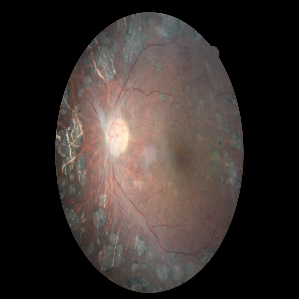

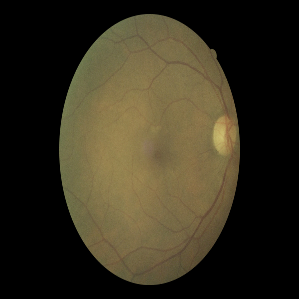

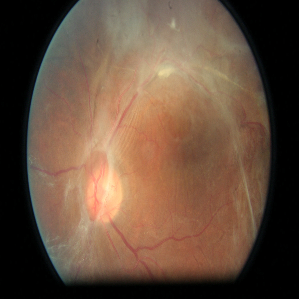

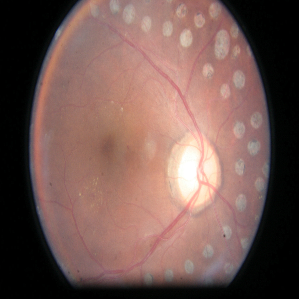

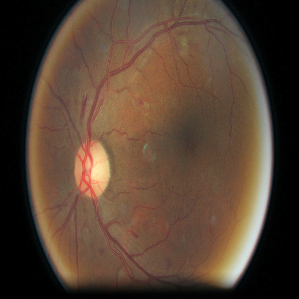

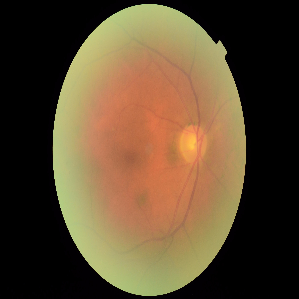

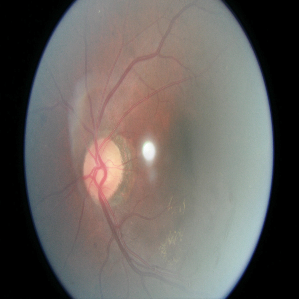

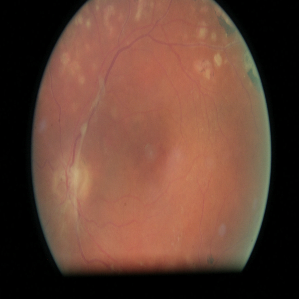

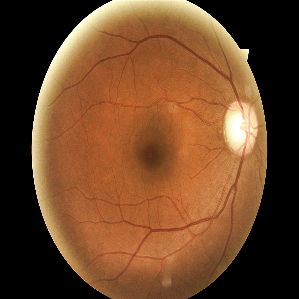

In [9]:
for i in range(0,9):
  cv2_imshow(data[i])

###Flattening and scale images

In [10]:
new_data = np.array(data)

In [11]:
new_data.shape

(2500, 299, 299, 3)

In [12]:
new_data = new_data/255.0

###Create label y

In [13]:
all_label = pd.read_csv("/content/trainLabels.csv")

In [14]:
all_label

image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
...            ...    ...
35121  44347_right      0
35122   44348_left      0
35123  44348_right      0
35124   44349_left      0
35125  44349_right      1

[35126 rows x 2 columns]

Let's check if the classes are balanced

In [15]:
print(all_label.groupby('level').nunique())

       image
level       
0      25810
1       2443
2       5292
3        873
4        708


Let's extract labels

In [16]:
label = []

In [17]:
file_dir = os.path.join('/content/train')
files = [os.path.join(file_dir, fname) for fname in DR_data]
for fname in DR_data:
  label.append(fname.split(".")[0]) 

In [18]:
label = pd.DataFrame(label,columns=['image'])

In [19]:
label

image
0      22568_left
1      4869_right
2     24910_right
3      17940_left
4     13591_right
...           ...
2495   1926_right
2496    877_right
2497     178_left
2498   1833_right
2499   20111_left

[2500 rows x 1 columns]

In [20]:
new_label = pd.merge(label, all_label, on=['image'])

In [21]:
new_label

image  level
0      22568_left      4
1      4869_right      1
2     24910_right      4
3      17940_left      4
4     13591_right      3
...           ...    ...
2495   1926_right      2
2496    877_right      2
2497     178_left      1
2498   1833_right      1
2499   20111_left      4

[2500 rows x 2 columns]

Check the balance of the classes

In [22]:
print(new_label.groupby('level').nunique())

       image
level       
0        500
1        500
2        500
3        500
4        500


Let's verify with first and last file name to see if it's matched.

In [23]:
DR_data[0], new_label['image'][0]

('22568_left.jpeg', '22568_left')

In [24]:
DR_data[500], new_label['image'][500]

('3562_right.jpeg', '3562_right')

In [25]:
DR_data[1000], new_label['image'][1000]

('560_right.jpeg', '560_right')

Therefore, the new label is created correctly and good to go!!!

In [26]:
target = new_label['level']

Split training and testing set 80:20

In [27]:
X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size=0.2, random_state=42)

Convert y to categorical 

In [28]:
class_name = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [29]:
y_train_cat = to_categorical(y_train, num_classes=len(class_name))

In [30]:
y_test_cat = to_categorical(y_test, num_classes=len(class_name))

###Data Augmentation

In [31]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=16, width_shift_range=0.2, shear_range=0.2, height_shift_range=0.2, zoom_range=0.2, 
                         featurewise_center=True, horizontal_flip=True, featurewise_std_normalization=True)
data_aug = gen.flow(X_train, y_train_cat, batch_size=20)

##Transfer Learning - Keras Model InceptionV3

In [32]:
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import regularizers, optimizers

In [33]:
#Instatiate some optimizers 
sgd = optimizers.SGD(learning_rate=0.001)
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [34]:
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

87916544/87910968 [==============================] - 2s 0us/step


In [35]:
#Freeze the early convolutional layers of the network
#and only train the last few layers which make a prediction
for layers in model.layers:
	layers.trainable=False

In [36]:
# New Layers which will be trained on our data set and will be stacked over the InceptionV3 Model
x = model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

In [37]:
V3_model=Model(model.input, output)
V3_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(V3_model, to_file='InceptionV3_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
V3_model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

##Training the model

In [64]:
tr1 = V3_model.fit(X_train,
                   y_train_cat,
                   batch_size=20, 
                   epochs=50,
                   validation_data=data_aug)

Epoch 1/50
100/100 [==============================] - 46s 458ms/step - loss: 0.0410 - accuracy: 0.9850 - val_loss: 0.1751 - val_accuracy: 0.9390
Epoch 2/50
100/100 [==============================] - 46s 456ms/step - loss: 0.0359 - accuracy: 0.9880 - val_loss: 0.0811 - val_accuracy: 0.9735
Epoch 3/50
100/100 [==============================] - 46s 458ms/step - loss: 0.0155 - accuracy: 0.9945 - val_loss: 0.0350 - val_accuracy: 0.9870
Epoch 4/50
100/100 [==============================] - 46s 457ms/step - loss: 0.0302 - accuracy: 0.9910 - val_loss: 0.0304 - val_accuracy: 0.9925
Epoch 5/50
100/100 [==============================] - 45s 454ms/step - loss: 0.0196 - accuracy: 0.9940 - val_loss: 0.0340 - val_accuracy: 0.9875
Epoch 6/50
100/100 [==============================] - 45s 452ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0350 - val_accuracy: 0.9895
Epoch 7/50
100/100 [==============================] - 45s 452ms/step - loss: 0.0169 - accuracy: 0.9940 - val_loss: 0.0972 - val_ac

###Plot the learning curve

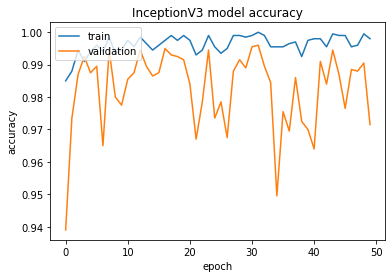

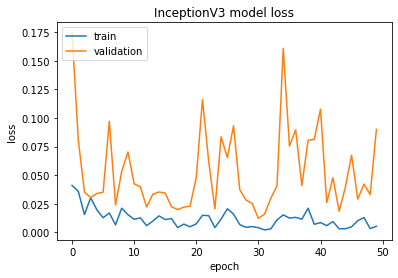

In [67]:
plt.plot(tr1.history['accuracy'])
plt.plot(tr1.history['val_accuracy'])
plt.title('InceptionV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr1.history['loss'])
plt.plot(tr1.history['val_loss'])
plt.title('InceptionV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##See the accuracy

In [65]:
train_score = V3_model.evaluate(X_train, y_train_cat, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

Train loss: 0.006941937375813723
Train accuracy: 0.9980000257492065


In [66]:
test_score = V3_model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 3.0262606143951416
Test accuracy: 0.49000000953674316


###See the prediction

In [68]:
pred_test = V3_model.predict(X_test, verbose=0)

In [69]:
pred_test = np.argmax(pred_test,axis=1)

In [70]:
pred_test

array([1, 3, 1, 2, 3, 4, 1, 0, 3, 4, 1, 2, 4, 0, 0, 1, 0, 4, 4, 2, 3, 4,
       0, 2, 4, 1, 1, 1, 3, 4, 1, 2, 4, 0, 0, 0, 4, 3, 2, 4, 4, 0, 2, 3,
       1, 2, 0, 1, 4, 2, 2, 2, 0, 0, 4, 1, 4, 0, 2, 0, 1, 3, 1, 0, 4, 0,
       2, 3, 0, 0, 3, 2, 0, 3, 0, 1, 2, 4, 2, 4, 0, 0, 1, 2, 0, 0, 2, 2,
       4, 1, 4, 1, 0, 0, 0, 2, 3, 4, 0, 2, 3, 4, 4, 4, 0, 0, 0, 2, 0, 3,
       0, 3, 0, 0, 2, 1, 4, 4, 2, 0, 2, 2, 3, 2, 3, 4, 2, 1, 1, 0, 4, 1,
       0, 2, 4, 1, 1, 3, 2, 3, 0, 1, 1, 1, 3, 2, 0, 1, 2, 0, 3, 4, 1, 4,
       1, 0, 2, 0, 4, 2, 0, 2, 2, 4, 0, 4, 3, 1, 4, 4, 0, 1, 3, 1, 1, 0,
       0, 4, 3, 3, 0, 2, 3, 1, 2, 0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 4, 0, 1,
       1, 0, 2, 4, 2, 3, 4, 2, 0, 3, 4, 0, 0, 0, 0, 4, 4, 0, 0, 1, 3, 4,
       2, 3, 0, 1, 0, 4, 4, 4, 4, 3, 0, 2, 0, 2, 0, 4, 0, 3, 0, 0, 0, 4,
       3, 0, 0, 0, 1, 3, 2, 0, 3, 4, 0, 0, 2, 3, 0, 4, 4, 0, 1, 4, 4, 0,
       4, 3, 4, 1, 4, 4, 1, 0, 4, 4, 4, 3, 0, 2, 0, 0, 0, 0, 3, 1, 0, 4,
       0, 3, 0, 1, 0, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1,

###Classification Report

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.42      0.76      0.54        94
            Mild       0.51      0.35      0.41       107
        Moderate       0.39      0.26      0.32       106
          Severe       0.56      0.43      0.49        98
Proliferative DR       0.59      0.71      0.64        95

        accuracy                           0.49       500
       macro avg       0.50      0.50      0.48       500
    weighted avg       0.49      0.49      0.47       500



###Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

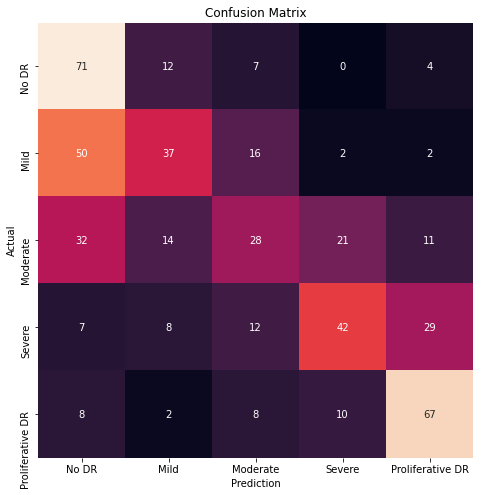

In [72]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

##Reduce Overfitting

In [74]:
#Apply regularizers and some dropout layers
x = model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu', activity_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', activity_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', activity_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

In [75]:
V3_model=Model(model.input, output)

In [76]:
V3_model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

In [77]:
callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

In [78]:
tr1 = V3_model.fit(X_train,
                   y_train_cat,
                   batch_size=20,
                   epochs=50,
                   validation_data=data_aug,
                   callbacks=[callback])

Epoch 1/50
100/100 [==============================] - 48s 478ms/step - loss: 1.6680 - accuracy: 0.4125 - val_loss: 1.2989 - val_accuracy: 0.8630
Epoch 2/50
100/100 [==============================] - 45s 454ms/step - loss: 1.2598 - accuracy: 0.6580 - val_loss: 0.9381 - val_accuracy: 0.9505
Epoch 3/50
100/100 [==============================] - 45s 452ms/step - loss: 1.0033 - accuracy: 0.8105 - val_loss: 0.7095 - val_accuracy: 0.9685
Epoch 4/50
100/100 [==============================] - 45s 449ms/step - loss: 0.8580 - accuracy: 0.8650 - val_loss: 0.5705 - val_accuracy: 0.9905
Epoch 5/50
100/100 [==============================] - 45s 447ms/step - loss: 0.7569 - accuracy: 0.8955 - val_loss: 0.5033 - val_accuracy: 0.9805
Epoch 6/50
100/100 [==============================] - 45s 449ms/step - loss: 0.6762 - accuracy: 0.9230 - val_loss: 0.4463 - val_accuracy: 0.9860
Epoch 7/50
100/100 [==============================] - 45s 448ms/step - loss: 0.6237 - accuracy: 0.9355 - val_loss: 0.3853 - val_ac

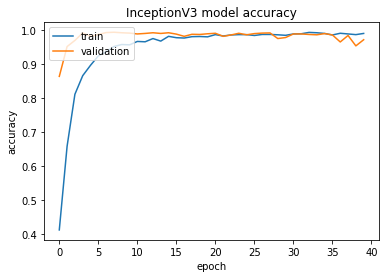

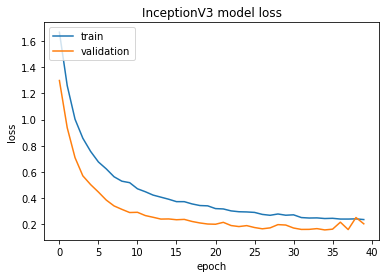

In [79]:
plt.plot(tr1.history['accuracy'])
plt.plot(tr1.history['val_accuracy'])
plt.title('InceptionV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr1.history['loss'])
plt.plot(tr1.history['val_loss'])
plt.title('InceptionV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Check the new accuracy

In [80]:
train_score = V3_model.evaluate(X_train, y_train_cat, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

Train loss: 0.1313014030456543
Train accuracy: 1.0


In [81]:
test_score = V3_model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 1.7433072328567505
Test accuracy: 0.5299999713897705


###See the prediction

In [82]:
pred_test = V3_model.predict(X_test, verbose=0)

In [83]:
pred_test = np.argmax(pred_test,axis=1)

###Classification Report

In [84]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.54      0.50      0.52        94
            Mild       0.43      0.59      0.50       107
        Moderate       0.40      0.29      0.34       106
          Severe       0.64      0.57      0.60        98
Proliferative DR       0.68      0.72      0.70        95

        accuracy                           0.53       500
       macro avg       0.54      0.53      0.53       500
    weighted avg       0.53      0.53      0.53       500



###Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

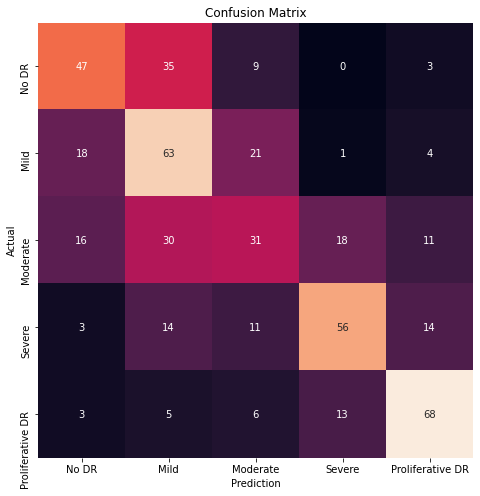

In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

In [86]:
#Save the model
from tensorflow.keras.models import load_model
V3_model.save('InceptionV3.h5')